In [2]:
import json

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
from tqdm import tqdm

In [3]:
nn_df = pl.read_csv("/kaggle/input/uspto-boolean-search-optimization/nearest_neighbors.csv")
nn_df.head(1)

publication_number,neighbor_0,neighbor_1,neighbor_2,neighbor_3,neighbor_4,neighbor_5,neighbor_6,neighbor_7,neighbor_8,neighbor_9,neighbor_10,neighbor_11,neighbor_12,neighbor_13,neighbor_14,neighbor_15,neighbor_16,neighbor_17,neighbor_18,neighbor_19,neighbor_20,neighbor_21,neighbor_22,neighbor_23,neighbor_24,neighbor_25,neighbor_26,neighbor_27,neighbor_28,neighbor_29,neighbor_30,neighbor_31,neighbor_32,neighbor_33,neighbor_34,neighbor_35,neighbor_36,neighbor_37,neighbor_38,neighbor_39,neighbor_40,neighbor_41,neighbor_42,neighbor_43,neighbor_44,neighbor_45,neighbor_46,neighbor_47,neighbor_48,neighbor_49
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""US-1-A""","""US-189152-A""","""US-1189501-A""","""US-409430-A""","""US-421894-A""","""US-9052-A""","""US-435641-A""","""US-247802-A""","""US-566579-A""","""US-148439-A""","""US-488484-A""","""US-1003894-A""","""US-951842-A""","""US-965846-A""","""US-733217-A""","""US-1681171-A""","""US-339-A""","""US-1206147-A""","""US-1213323-A""","""US-9716-A""","""US-882618-A""","""US-1161812-A""","""US-6321-A""","""US-3267876-A""","""US-1136947-A""","""US-1097810-A""","""US-939423-A""","""US-986261-A""","""US-975048-A""","""US-95968-A""","""US-5532-A""","""US-393896-A""","""US-156138-A""","""US-144271-A""","""US-357649-A""","""US-1182286-A""","""US-1342938-A""","""US-1329037-A""","""US-42039-A""","""US-3237572-A""","""US-462944-A""","""US-1108807-A""","""US-1393935-A""","""US-45450-A""","""US-381847-A""","""US-1354714-A""","""US-661045-A""","""US-737513-A""","""US-447255-A""","""US-1510390-A""","""US-1075814-A"""


In [4]:
with open("/kaggle/input/uspto-boolean-search-optimization/train_index_patent_ids.json", "r") as f:
    indexs = set(json.load(f))
len(indexs)

200000

In [24]:
meta = pl.read_parquet("/kaggle/input/uspto-boolean-search-optimization/patent_metadata.parquet")
meta = meta.with_columns(pl.col("publication_date").dt.year().alias("year"))
meta.head(1)

publication_number,publication_date,filing_date,family_id,cpc_codes,year
str,datetime[μs],datetime[μs],f64,list[str],i32
"""US-1-A""",1836-07-13 00:00:00,null,2.060279e6,"[""B61C11/04""]",1836


---
### 全てのneighborが含まれる`publication_number`

In [5]:
all_included_patents = []
n_includes = []
for ids in tqdm(nn_df.iter_rows()):
    center_patent_id = ids[0]
    nn_patent_ids = set(ids[1:])
    n_include = len(nn_patent_ids.intersection(indexs))
    if n_include == 50:
        all_included_patents.append(center_patent_id)
    n_includes.append(n_include)

13307647it [01:29, 149262.18it/s]


In [6]:
len(all_included_patents), np.mean(sorted(n_includes, reverse=True)[:2500])

(0, 6.422)

---
### train_indexとnn_dfの構成

In [14]:
nn_df["publication_number"].str.slice(0, 4).value_counts().sort("publication_number").with_columns(
    pl.col("counts") / len(nn_df)
)

publication_number,counts
str,f64
"""US-1""",0.175428
"""US-2""",0.268894
"""US-3""",0.082375
"""US-4""",0.081432
"""US-5""",0.074751
"""US-6""",0.069157
"""US-7""",0.065465
"""US-8""",0.06434
"""US-9""",0.062578


In [18]:
train_index_df = pl.DataFrame({"publication_number": list(indexs)})

train_index_df["publication_number"].str.slice(0, 4).value_counts().sort(
    "publication_number"
).with_columns(pl.col("counts") / len(train_index_df))

publication_number,counts
str,f64
"""US-1""",0.140125
"""US-2""",0.2823
"""US-3""",0.015555
"""US-4""",0.11029
"""US-5""",0.10169
"""US-6""",0.09063
"""US-7""",0.08666
"""US-8""",0.08559
"""US-9""",0.08175


---
### 発行年の分布

In [25]:
patent2year = dict(zip(meta["publication_number"], meta["year"]))

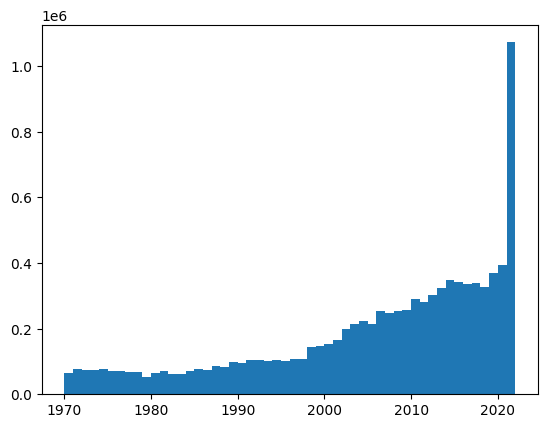

In [28]:
years = [year for year in patent2year.values() if year]
plt.hist(years, bins=range(1970, 2023))
plt.show()

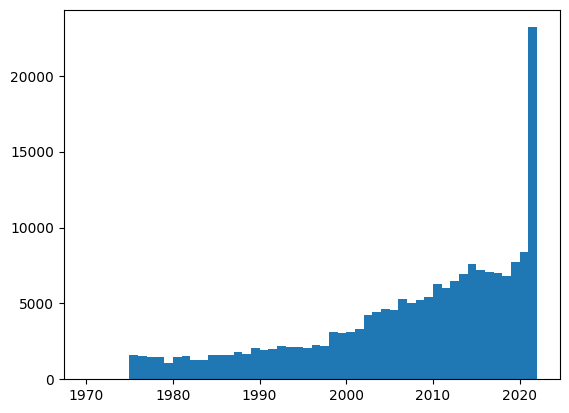

In [29]:
index_years = [patent2year[patent] for patent in indexs if patent in patent2year]
index_years = [year for year in index_years if year]
plt.hist(index_years, bins=range(1970, 2023))
plt.show()

10003050


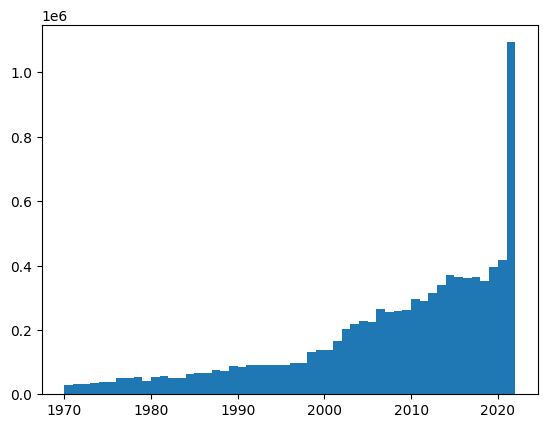

In [31]:
index_neighbor_df = nn_df.filter(pl.col("publication_number").is_in(indexs))
index_neighbors = []
for i in range(50):
    index_neighbors.extend(index_neighbor_df["neighbor_" + str(i)].to_list())
print(len(index_neighbors))

index_neighbor_years = [patent2year[patent] for patent in index_neighbors if patent in patent2year]
index_neighbor_years = [year for year in index_neighbor_years if year]
plt.hist(index_neighbor_years, bins=range(1970, 2023))
plt.show()